<a href="https://colab.research.google.com/github/ttakizawa/pytorch_sample/blob/main/classification/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler

## Prepare Dataset

In [2]:
def create_datasets(batch_size):

    # percentage of training set to use as validation
    valid_size = 0.2

    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(root='data', 
                                train=True,
                                download=True, 
                                transform=transform)

    test_data = datasets.MNIST(root='data',
                               train=False,
                               download=True,
                               transform=transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

## Eary Stopping

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Define Model

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## Training Loop

In [5]:
def train(device, model, batch_size, loss_fn, optimizer, patience, n_epochs, train_loader, valid_loader):
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):
      # train the model 
      model.train() # prep model for training
      for batch, (data, target) in enumerate(train_loader, 1):
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = loss_fn(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # record training loss
        train_losses.append(loss.item())

      # validate the model 
      model.eval() # prep model for evaluation
      for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = loss_fn(output, target)
        # record validation loss
        valid_losses.append(loss.item())
      
      # print training/validation statistics 
      # calculate average loss over an epoch
      train_loss = np.average(train_losses)
      valid_loss = np.average(valid_losses)
      avg_train_losses.append(train_loss)
      avg_valid_losses.append(valid_loss)

      epoch_len = len(str(n_epochs))
        
      print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')
      
      print(print_msg)
      
      # clear lists to track next epoch
      train_losses = []
      valid_losses = []
      
      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
      early_stopping(valid_loss, model)
      
      if early_stopping.early_stop:
          print("Early stopping")
          break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [11]:
batch_size = 256
n_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# data loader
train_loader, test_loader, valid_loader = create_datasets(batch_size)

# model
model = NeuralNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# early stopping patience; how long to wait after last time validation loss improved.
patience = 20

model, train_loss, valid_loss = train(device, model, batch_size, loss_fn, optimizer, patience, n_epochs, train_loader, valid_loader)

Using cuda device
[  1/100] train_loss: 0.84388 valid_loss: 0.30569
Validation loss decreased (inf --> 0.305685).  Saving model ...
[  2/100] train_loss: 0.37115 valid_loss: 0.22445
Validation loss decreased (0.305685 --> 0.224453).  Saving model ...
[  3/100] train_loss: 0.29953 valid_loss: 0.18656
Validation loss decreased (0.224453 --> 0.186560).  Saving model ...
[  4/100] train_loss: 0.26567 valid_loss: 0.15975
Validation loss decreased (0.186560 --> 0.159750).  Saving model ...
[  5/100] train_loss: 0.23787 valid_loss: 0.14324
Validation loss decreased (0.159750 --> 0.143238).  Saving model ...
[  6/100] train_loss: 0.21602 valid_loss: 0.13235
Validation loss decreased (0.143238 --> 0.132346).  Saving model ...
[  7/100] train_loss: 0.20515 valid_loss: 0.12769
Validation loss decreased (0.132346 --> 0.127686).  Saving model ...
[  8/100] train_loss: 0.19143 valid_loss: 0.11774
Validation loss decreased (0.127686 --> 0.117738).  Saving model ...
[  9/100] train_loss: 0.17980 valid

## Visualizing the Loss and the Early Stopping Checkpoint

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

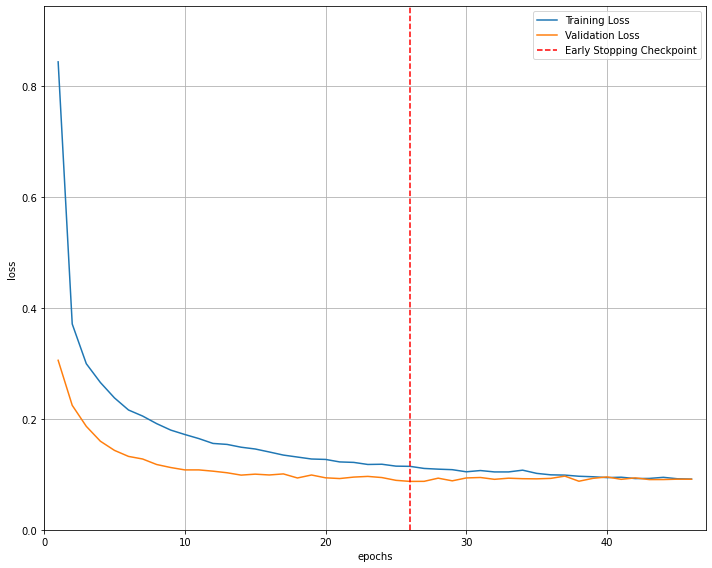

In [13]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, max(np.max(valid_loss), np.max(train_loss) + 0.1)) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [18]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if len(target.data) != batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    data, target = data.to(device), target.to(device)
    output = model(data)
    # calculate the loss
    loss = loss_fn(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.091806

Test Accuracy of     0: 99% (971/979)
Test Accuracy of     1: 99% (1122/1133)
Test Accuracy of     2: 97% (1004/1030)
Test Accuracy of     3: 97% (985/1008)
Test Accuracy of     4: 97% (959/980)
Test Accuracy of     5: 96% (859/890)
Test Accuracy of     6: 97% (928/956)
Test Accuracy of     7: 97% (1001/1027)
Test Accuracy of     8: 96% (938/973)
Test Accuracy of     9: 96% (968/1008)

Test Accuracy (Overall): 97% (9735/9984)


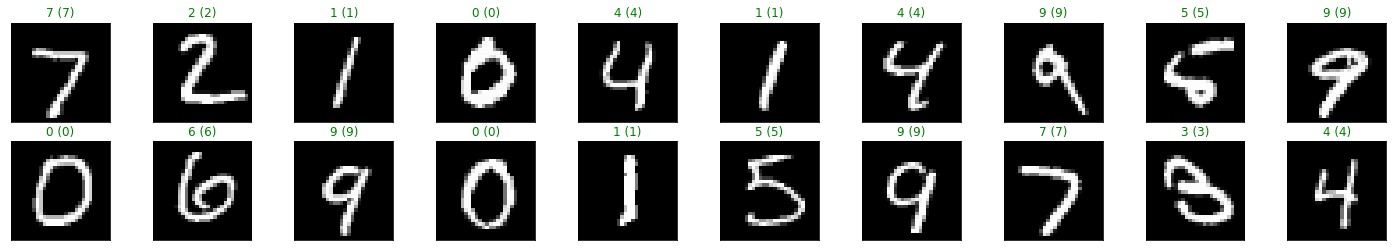

In [21]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))